In [38]:
# Course : CS 513 - Knowledge Discovery and Data Mining
# Group Members: Branden Bulatao, Joseph Faustino, Natalie Fortes, Isabel Sutedjo
# Id : 20005971
# Purpose : Music Happiness Predictor - Predicts the happiness of music tracks based on various features.

# Main Author: Branden Bulatao

In [50]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [51]:
# Import dataset
df = pd.read_csv("./dataset.csv")

df.drop(
    df.columns[df.columns.str.contains("unnamed", case=False)], axis=1, inplace=True
)  # drop unnamed column

df.dropna(inplace=True)  # drop rows with null values

df["valence"] = df["valence"].astype("category")
df["valence"] = df["valence"].map( lambda x: 0 if x < 0.5 else 1)  # sets valence to 0 if sad, 1 if happy

# Convert 'explicit' boolean to integer (0/1)
df["explicit"] = df["explicit"].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=["key", "time_signature", "track_genre"], drop_first=True)

# Separate target variable and attributing features
X = df.drop(["track_id", "artists", "album_name", "track_name", "valence", "duration_ms"], axis=1)
y = df["valence"]


# Identify numeric features to scale
numeric_features = [
    # "popularity",
    # "duration_ms",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    # "liveness",
    # "tempo",
]

numeric_high_value_features = [
    "popularity",
    "tempo",
    "loudness",
]

# All other features (binary or one-hot) are left as-is
non_scaled_features = [
    col
    for col in X.columns
    if col not in (numeric_features and numeric_high_value_features)
]
# non_scaled_features = [col for col in X.columns if col not in numeric_high_value_features]

# ColumnTransformer for selective scaling
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", MinMaxScaler(), numeric_features),
        ("num2", MinMaxScaler(), numeric_high_value_features),
        ("pass", "passthrough", non_scaled_features),
    ]
)

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

# Reconstruct a DataFrame (optional, for inspection/debugging)
X_processed = pd.DataFrame(
    X_processed, columns=numeric_high_value_features + non_scaled_features
)
# X_processed = pd.DataFrame(X_processed, columns=numeric_features + numeric_high_value_features + non_scaled_features)


# Train the code
attr_train, attr_test, target_train, target_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42
)

print(df.head(1))

target_train.head()
# attr_train.head()
target_test.head()

                 track_id      artists album_name track_name  popularity  \
0  5SuOikwiRyPMVoIQDJUgSV  Gen Hoshino     Comedy     Comedy          73   

   duration_ms  explicit  danceability  energy  loudness  ...  \
0       230666         0         0.676   0.461    -6.746  ...   

   track_genre_spanish  track_genre_study  track_genre_swedish  \
0                False              False                False   

   track_genre_synth-pop  track_genre_tango  track_genre_techno  \
0                  False              False               False   

   track_genre_trance  track_genre_trip-hop  track_genre_turkish  \
0               False                 False                False   

   track_genre_world-music  
0                    False  

[1 rows x 145 columns]


113186    0
42819     0
59311     0
90417     0
61000     1
Name: valence, dtype: int64

In [40]:
# Import dataset
df = pd.read_csv('./dataset.csv')

df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True) # drop unnamed column
df.dropna(inplace=True) # drop rows with null values

df['valence'] = df['valence'].astype('category')
df['valence'] = df['valence'].map(lambda x: 0 if x < 0.5 else 1) # sets valence to 0 if sad, 1 if happy

# Convert 'explicit' boolean to integer (0/1)
df['explicit'] = df['explicit'].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['key', 'time_signature', 'track_genre'], drop_first=True)

# Scalar
scalar = MinMaxScaler()

# X = df.drop(['track_id', 'artists', 'album_name', 'track_name', 'valence'], axis=1)
X = df.drop(['track_id', 'artists', 'album_name', 'track_name', 'valence'], axis=1)
y = df['valence']
X = pd.DataFrame(scalar.fit_transform(X), columns=X.columns)

# Train the code
attr_train, attr_test, target_train, target_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(df.head(1))

target_train.head()
# attr_train.head()
target_test.head()

                 track_id      artists album_name track_name  popularity  \
0  5SuOikwiRyPMVoIQDJUgSV  Gen Hoshino     Comedy     Comedy          73   

   duration_ms  explicit  danceability  energy  loudness  ...  \
0       230666         0         0.676   0.461    -6.746  ...   

   track_genre_spanish  track_genre_study  track_genre_swedish  \
0                False              False                False   

   track_genre_synth-pop  track_genre_tango  track_genre_techno  \
0                  False              False               False   

   track_genre_trance  track_genre_trip-hop  track_genre_turkish  \
0               False                 False                False   

   track_genre_world-music  
0                    False  

[1 rows x 145 columns]


113186    0
42819     0
59311     0
90417     0
61000     1
Name: valence, dtype: int64

In [52]:
# Train Naive Bayes model
model = GaussianNB()
model.fit(attr_train, target_train)

# Make Prediction
target_pred = model.predict(attr_test)

In [53]:
# Evaluate model
accuracy = accuracy_score(target_test, target_pred)
conf_matrix = confusion_matrix(target_test, target_pred)
class_report = classification_report(target_test, target_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.6906

Confusion Matrix:
 [[11980  6591]
 [ 3992 11637]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.69     18571
           1       0.64      0.74      0.69     15629

    accuracy                           0.69     34200
   macro avg       0.69      0.69      0.69     34200
weighted avg       0.70      0.69      0.69     34200



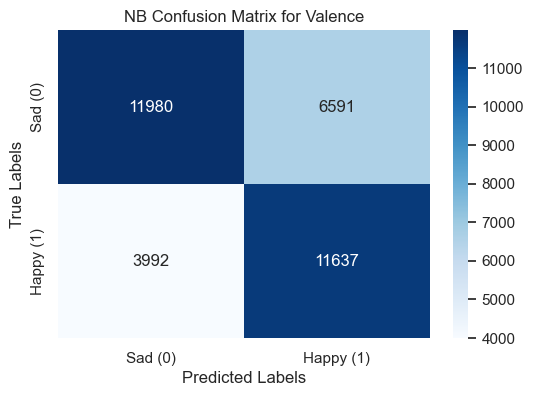

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(target_test, target_pred)

# Create the heatmap
plt.figure(figsize=(6, 4))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", ax=ax)

# Labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("NB Confusion Matrix for Valence")
ax.xaxis.set_ticklabels(["Sad (0)", "Happy (1)"])
ax.yaxis.set_ticklabels(["Sad (0)", "Happy (1)"])

plt.show()

In [55]:
test_actual = attr_test  # Copy attr_test
test_actual["target_pred"] = target_pred  # Create new column for prediction values
test_actual["test_actual"] = target_test  # Create new column for actual values
# test_actual.head()  # Show table

false_positives = test_actual[
    (test_actual["target_pred"] == 1) & (test_actual["test_actual"] == 0)
]

false_negatives = test_actual[
    (test_actual["target_pred"] == 0) & (test_actual["test_actual"] == 1)
]

true_positives = test_actual[
    (test_actual["target_pred"] == 1) & (test_actual["test_actual"] == 1)
]

true_negatives = test_actual[
    (test_actual["target_pred"] == 0) & (test_actual["test_actual"] == 0)
]

print(false_positives)
print(false_negatives)
# false_positives.describe()

       popularity     tempo  loudness explicit danceability energy mode  \
19261         0.0  0.573575   0.63106        0        0.469  0.183    1   
115           0.6  0.606269  0.771933        0        0.633  0.299    1   
88580         0.0  0.402495  0.817343        0        0.786  0.696    0   
60735        0.19  0.497177    0.6857        0        0.911  0.616    1   
3241          0.0  0.648904  0.861291        0        0.416  0.964    1   
...           ...       ...       ...      ...          ...    ...  ...   
84333        0.56  0.421404  0.642473        0        0.653  0.472    1   
52481        0.13  0.349613  0.660193        0        0.472  0.181    1   
103113        0.0  0.412471  0.756969        0        0.637  0.745    1   
112151       0.48  0.472569  0.765681        0        0.748  0.646    0   
53782        0.62  0.369648  0.891349        1        0.687  0.915    1   

       speechiness acousticness instrumentalness  ... track_genre_swedish  \
19261       0.0407    

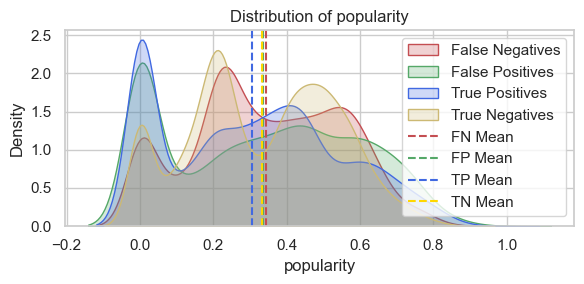

Stats for 'popularity':
  False Negatives - mean: 0.3438, std: 0.2031
  False Positives - mean: 0.3347, std: 0.2535
  True Positives  - mean: 0.3060, std: 0.2360
  True Negatives  - mean: 0.3325, std: 0.1991
------------------------------------------------------------


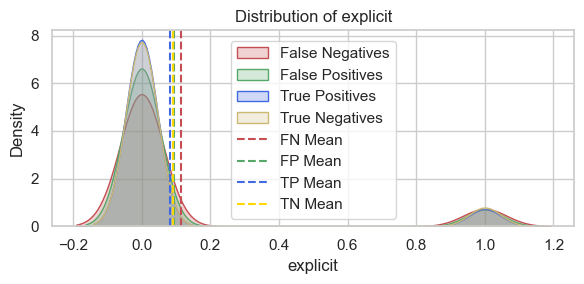

Stats for 'explicit':
  False Negatives - mean: 0.1154, std: 0.3195
  False Positives - mean: 0.0955, std: 0.2939
  True Positives  - mean: 0.0841, std: 0.2775
  True Negatives  - mean: 0.0919, std: 0.2888
------------------------------------------------------------


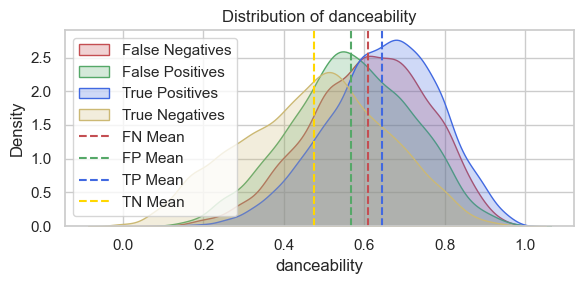

Stats for 'danceability':
  False Negatives - mean: 0.6099, std: 0.1471
  False Positives - mean: 0.5666, std: 0.1517
  True Positives  - mean: 0.6447, std: 0.1396
  True Negatives  - mean: 0.4754, std: 0.1786
------------------------------------------------------------


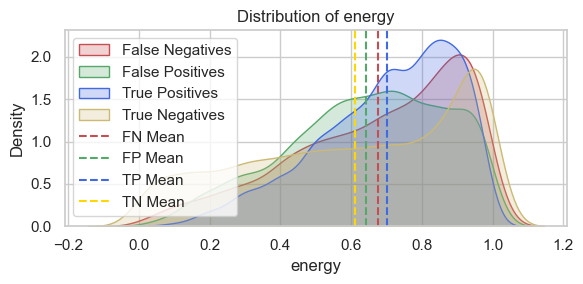

Stats for 'energy':
  False Negatives - mean: 0.6761, std: 0.2387
  False Positives - mean: 0.6410, std: 0.2242
  True Positives  - mean: 0.7008, std: 0.1933
  True Negatives  - mean: 0.6097, std: 0.2984
------------------------------------------------------------


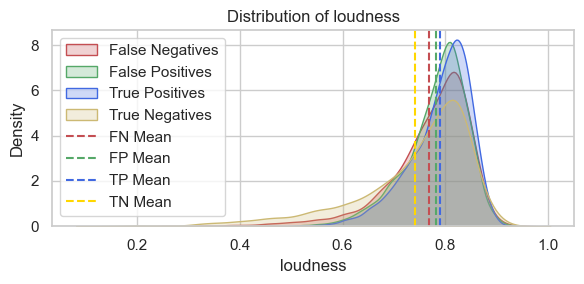

Stats for 'loudness':
  False Negatives - mean: 0.7688, std: 0.0826
  False Positives - mean: 0.7813, std: 0.0619
  True Positives  - mean: 0.7895, std: 0.0602
  True Negatives  - mean: 0.7405, std: 0.1157
------------------------------------------------------------


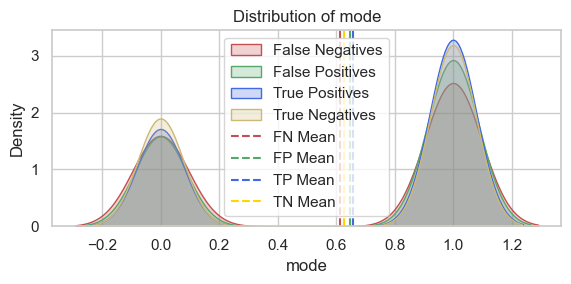

Stats for 'mode':
  False Negatives - mean: 0.6130, std: 0.4871
  False Positives - mean: 0.6490, std: 0.4773
  True Positives  - mean: 0.6572, std: 0.4747
  True Negatives  - mean: 0.6271, std: 0.4836
------------------------------------------------------------


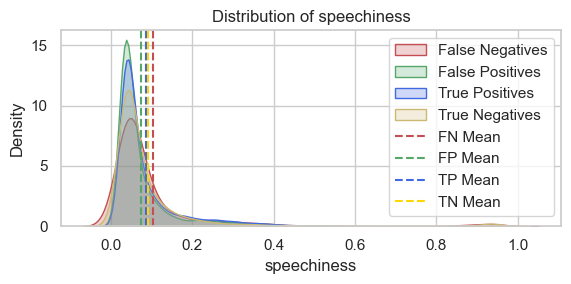

Stats for 'speechiness':
  False Negatives - mean: 0.1036, std: 0.1505
  False Positives - mean: 0.0753, std: 0.0800
  True Positives  - mean: 0.0859, std: 0.0896
  True Negatives  - mean: 0.0925, std: 0.1351
------------------------------------------------------------


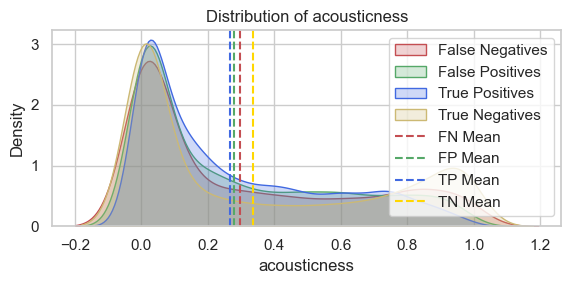

Stats for 'acousticness':
  False Negatives - mean: 0.2972, std: 0.3324
  False Positives - mean: 0.2785, std: 0.3012
  True Positives  - mean: 0.2671, std: 0.2767
  True Negatives  - mean: 0.3355, std: 0.3758
------------------------------------------------------------


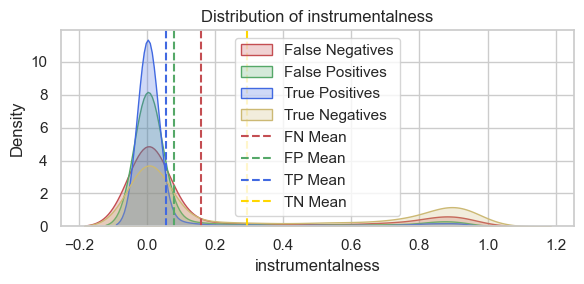

Stats for 'instrumentalness':
  False Negatives - mean: 0.1584, std: 0.3067
  False Positives - mean: 0.0799, std: 0.2207
  True Positives  - mean: 0.0549, std: 0.1829
  True Negatives  - mean: 0.2929, std: 0.3819
------------------------------------------------------------


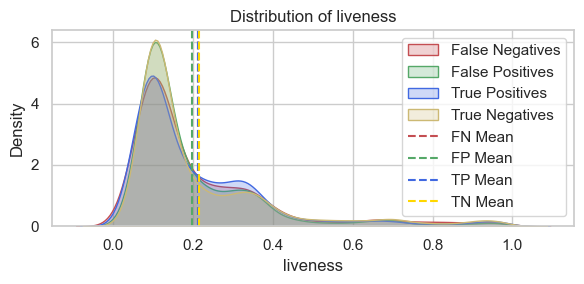

Stats for 'liveness':
  False Negatives - mean: 0.2123, std: 0.1862
  False Positives - mean: 0.1981, std: 0.1682
  True Positives  - mean: 0.2121, std: 0.1828
  True Negatives  - mean: 0.2152, std: 0.1909
------------------------------------------------------------


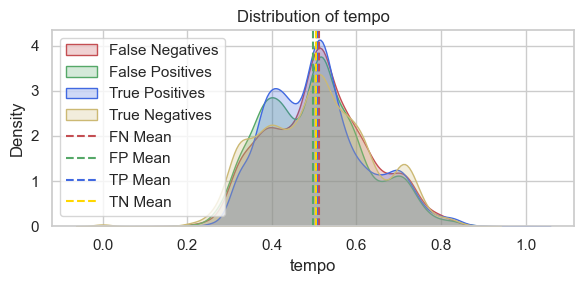

Stats for 'tempo':
  False Negatives - mean: 0.5118, std: 0.1191
  False Positives - mean: 0.4984, std: 0.1186
  True Positives  - mean: 0.5071, std: 0.1159
  True Negatives  - mean: 0.5048, std: 0.1295
------------------------------------------------------------


In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

df_no_genres = df.loc[:, ~df.columns.str.contains("track_genre")]

feature_cols = [
    col
    for col in df_no_genres.columns
    if col
    not in [
        "target_actual",
        "target_pred",
        "track_id",
        "artists",
        "album_name",
        "track_name",
        "valence",
    ]
]

KF_df = df.drop(columns="valence")
for col in df_no_genres.select_dtypes(include=["float", "int"]).columns:
    if col == "valence" or col == "duration_ms": continue
   
    plt.figure(figsize=(6, 3))

    # KDE plots
    sns.kdeplot(false_negatives[col], label="False Negatives", fill=True, color="r")
    sns.kdeplot(false_positives[col], label="False Positives", fill=True, color="g")
    sns.kdeplot(
        true_positives[col], label="True Positives", fill=True, color="royalblue"
    )
    sns.kdeplot(true_negatives[col], label="True Negatives", fill=True, color="y")

    # Vertical lines for means
    plt.axvline(false_negatives[col].mean(), color="r", linestyle="--", label="FN Mean")
    plt.axvline(false_positives[col].mean(), color="g", linestyle="--", label="FP Mean")
    plt.axvline(
        true_positives[col].mean(), color="royalblue", linestyle="--", label="TP Mean"
    )
    plt.axvline(
        true_negatives[col].mean(), color="gold", linestyle="--", label="TN Mean"
    )

    plt.title(f"Distribution of {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Stats for '{col}':")
    print(
        f"  False Negatives - mean: {false_negatives[col].mean():.4f}, std: {false_negatives[col].std():.4f}"
    )
    print(
        f"  False Positives - mean: {false_positives[col].mean():.4f}, std: {false_positives[col].std():.4f}"
    )
    print(
        f"  True Positives  - mean: {true_positives[col].mean():.4f}, std: {true_positives[col].std():.4f}"
    )
    print(
        f"  True Negatives  - mean: {true_negatives[col].mean():.4f}, std: {true_negatives[col].std():.4f}"
    )
    print("-" * 60)

['popularity', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']


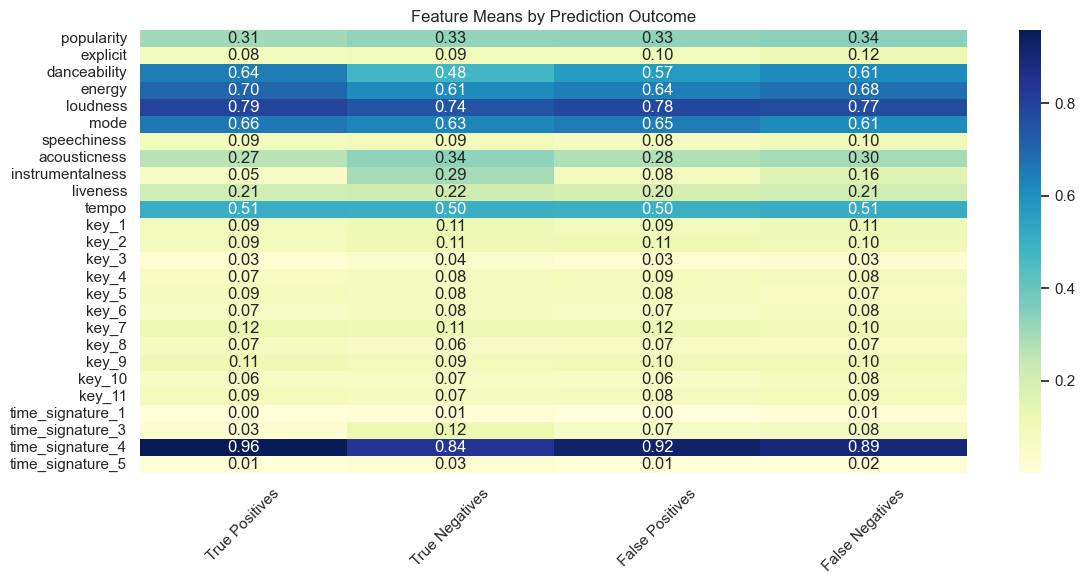

instrumentalness std deviation:  0.10707941147512356


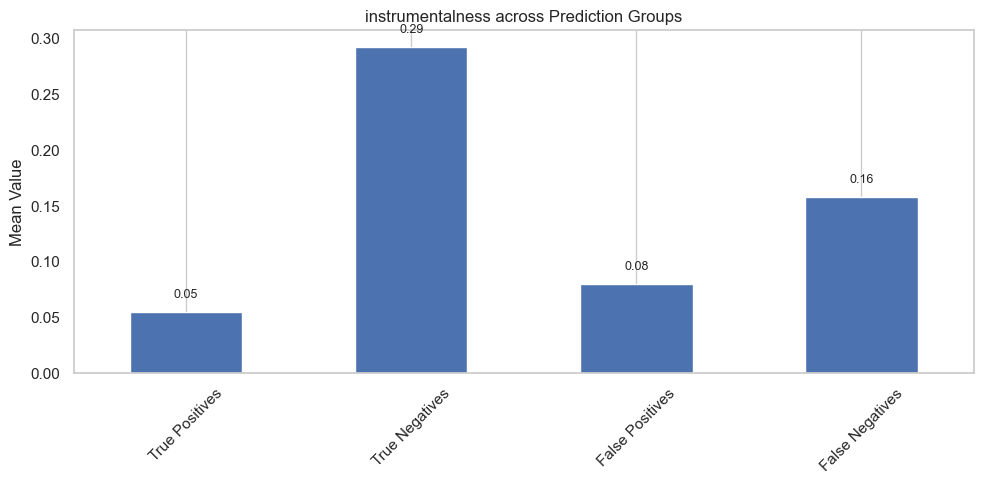

danceability std deviation:  0.07317519211706579


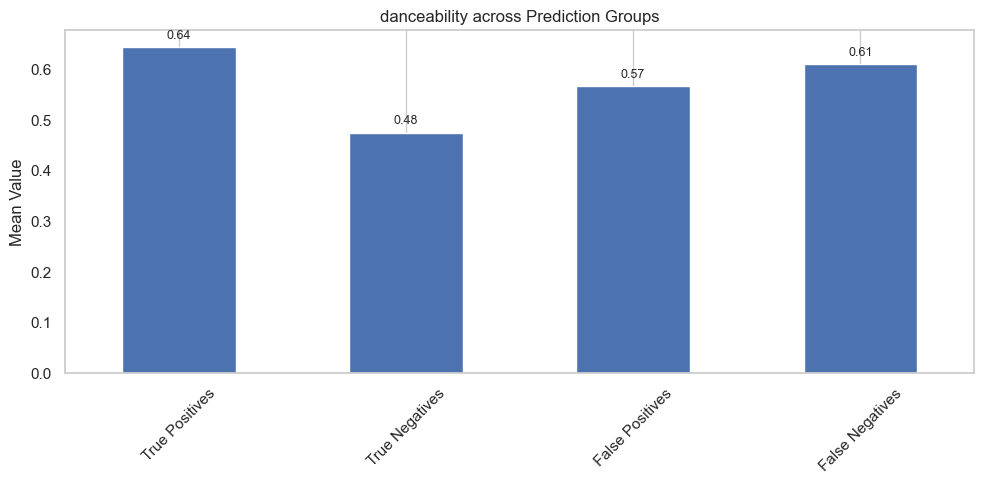

time_signature_4 std deviation:  0.05159847856490861


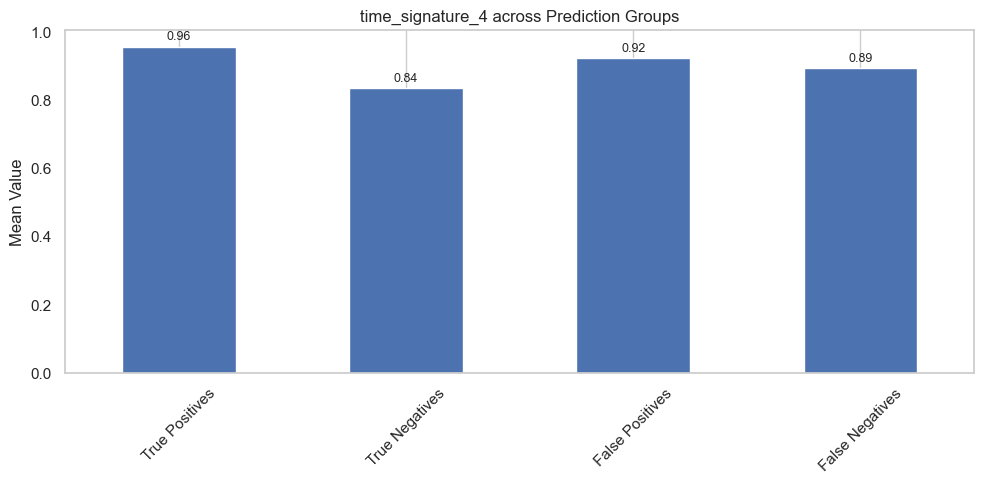

energy std deviation:  0.039890952024254994


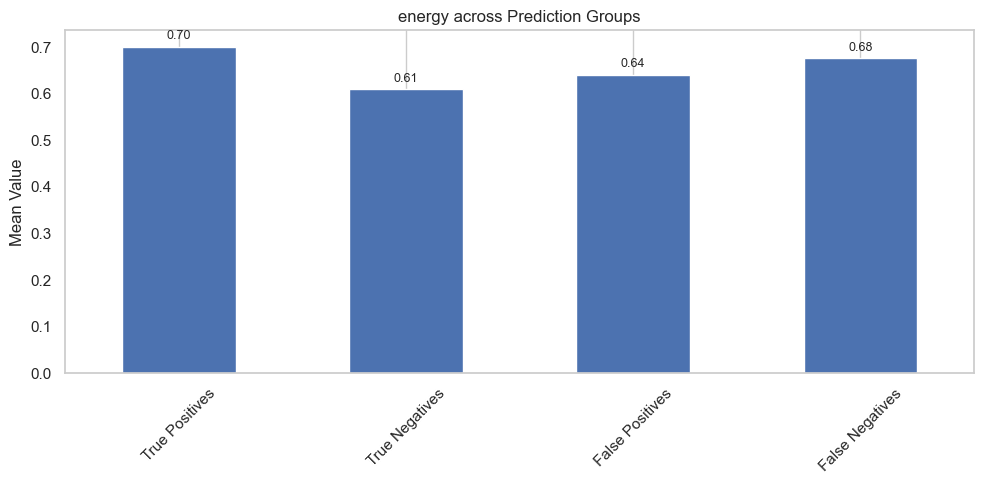

time_signature_3 std deviation:  0.037794911962863775


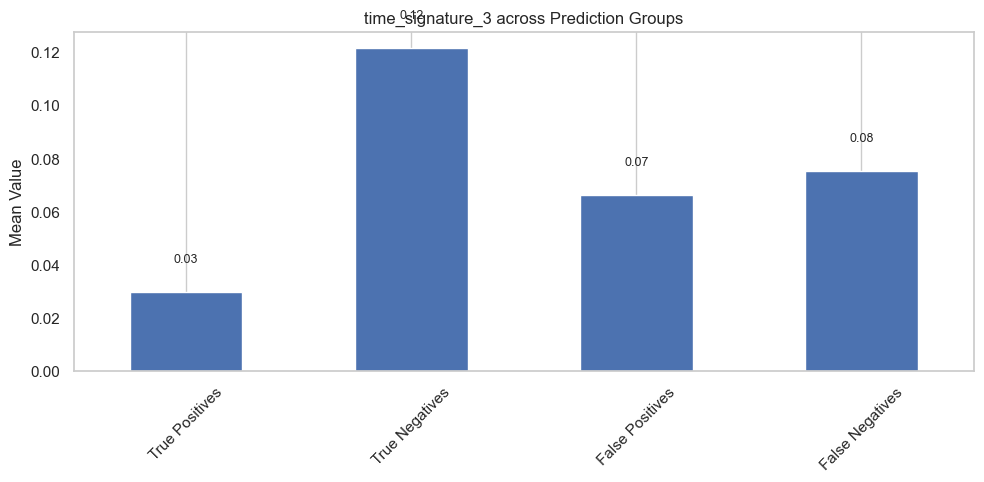

acousticness std deviation:  0.02996964681075159


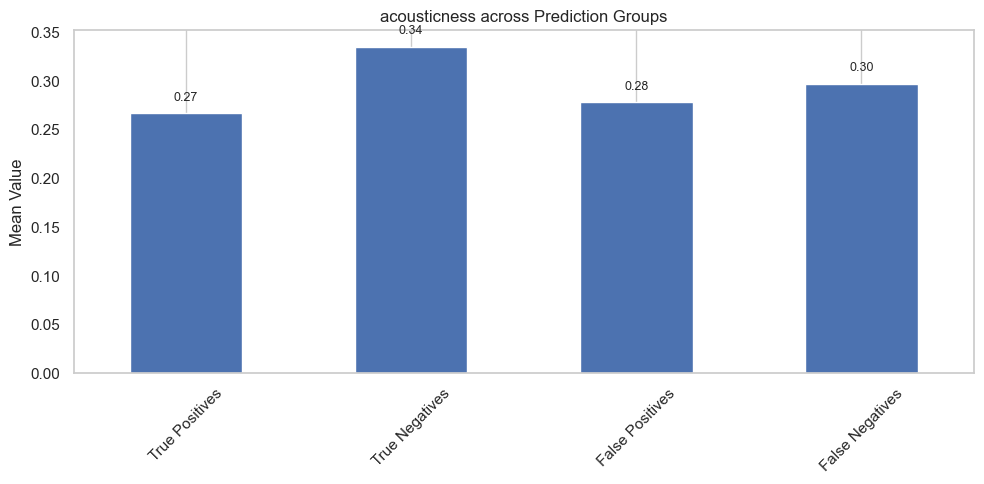

loudness std deviation:  0.02146320522456237


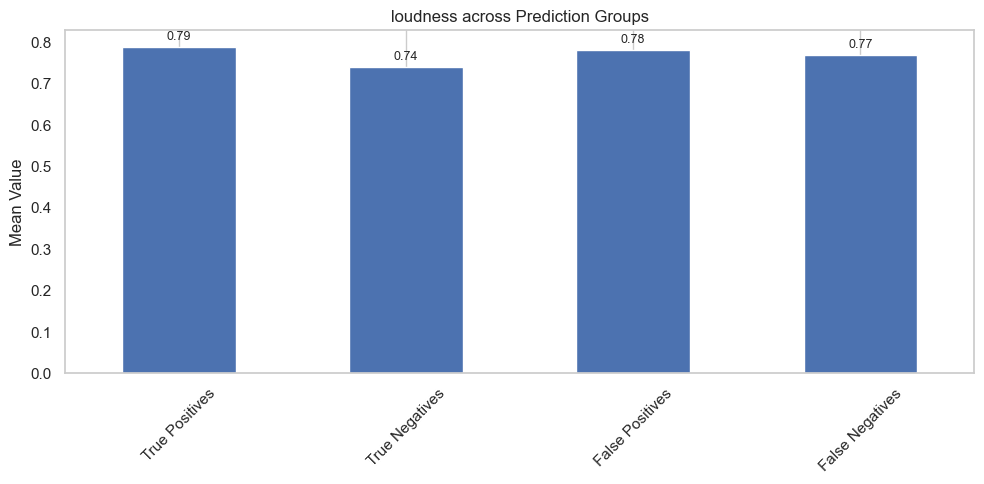

mode std deviation:  0.020186893313952955


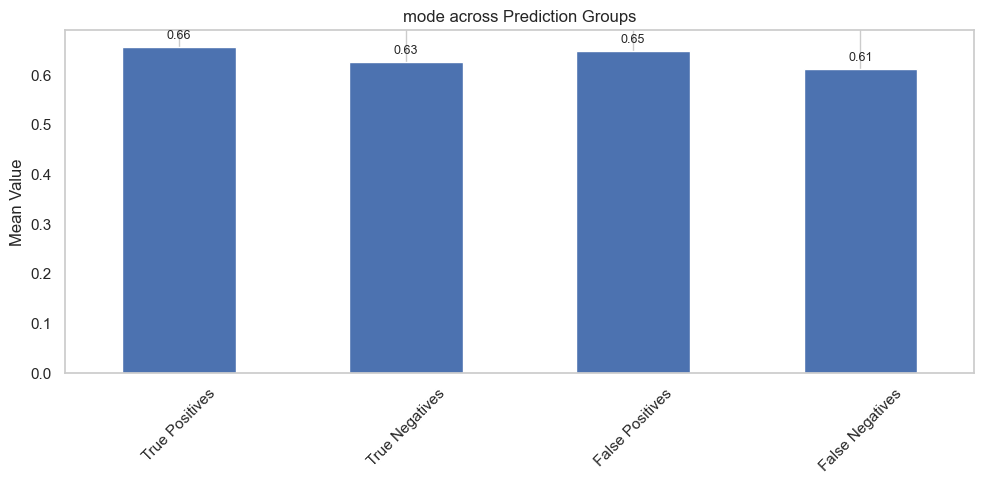

popularity std deviation:  0.016242792886740853


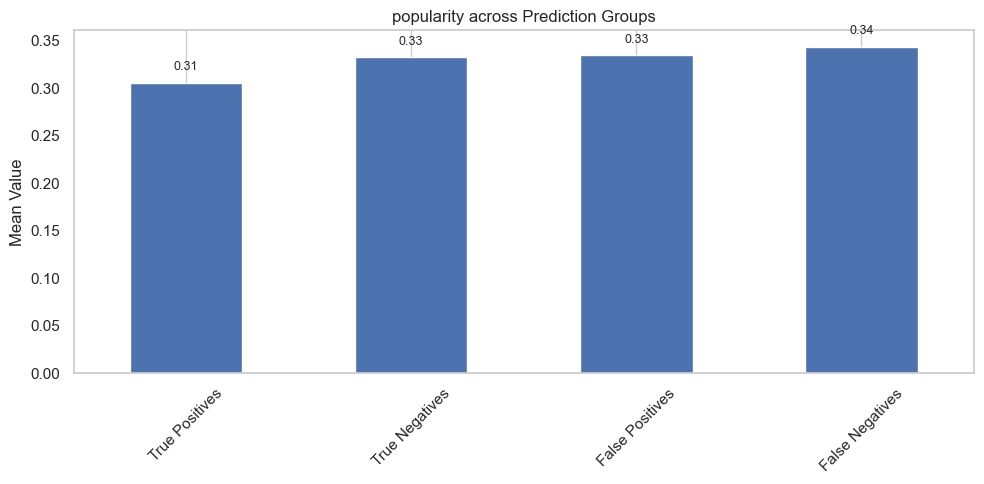

explicit std deviation:  0.013333688354700047


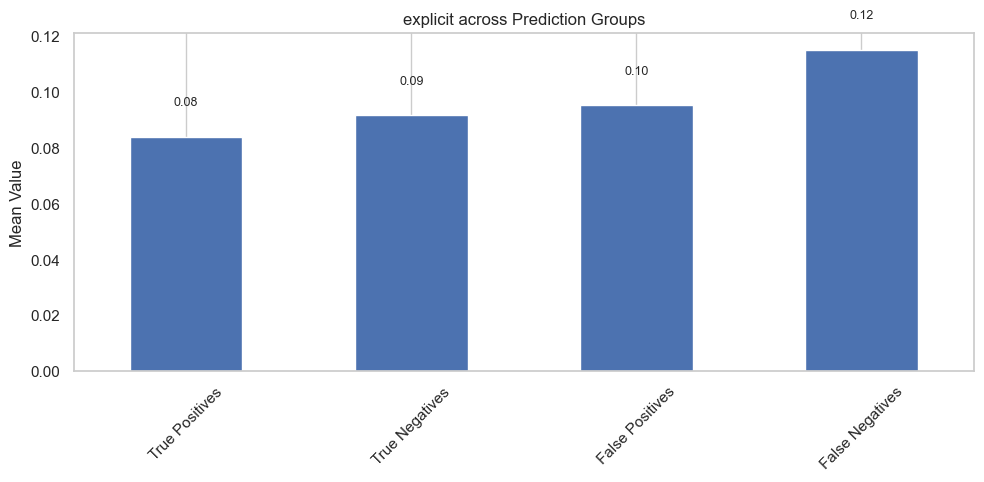

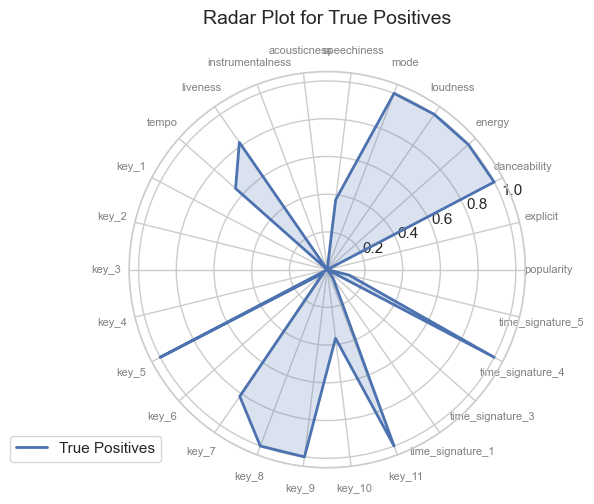

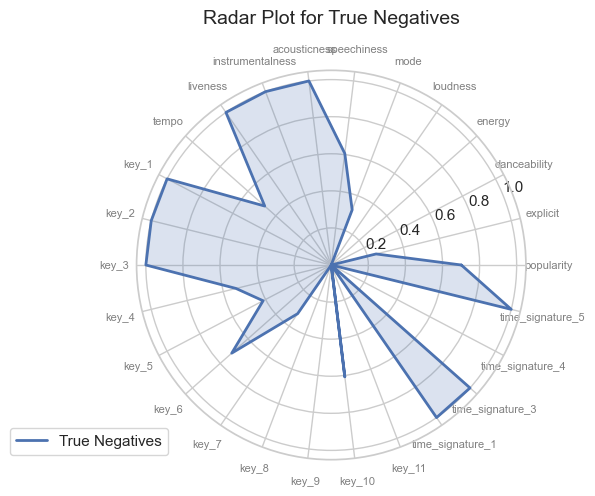

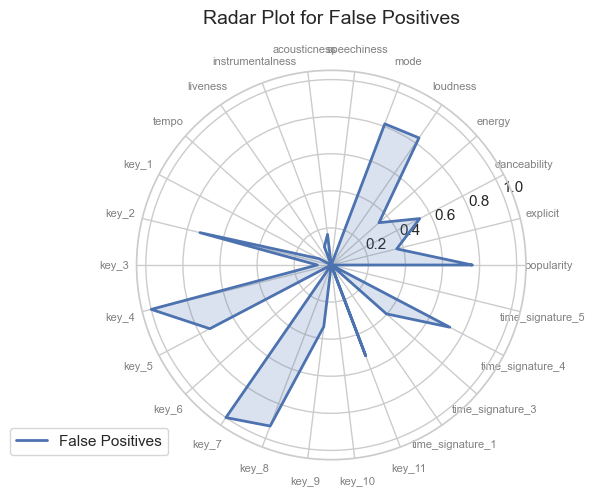

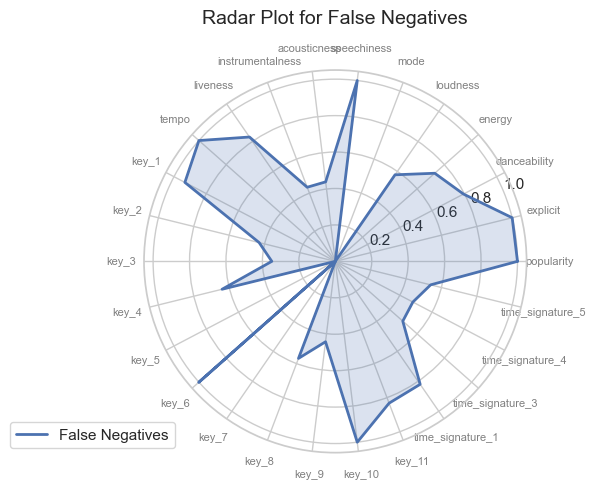

In [69]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

df_no_genres = df.loc[:, ~df.columns.str.contains("track_genre")]

# Features only (adjust as needed)
feature_cols = [
    col
    for col in df_no_genres.columns
    if col
    not in [
        "target_actual",
        "target_pred",
        "track_id",
        "artists",
        "album_name",
        "track_name",
        "valence",
        "duration_ms",
    ]
]

print(feature_cols)

# Mean summary per category
summary_df = pd.DataFrame(
    {
        "True Positives": true_positives[feature_cols].mean(),
        "True Negatives": true_negatives[feature_cols].mean(),
        "False Positives": false_positives[feature_cols].mean(),
        "False Negatives": false_negatives[feature_cols].mean(),
        # "All Data": df[feature_cols].mean(),
    }
)

# Transpose for easier plotting
summary_df = summary_df.astype(float)
summary_df = summary_df.T

# Optional: Normalize columns for radar/spider-style plots
summary_norm = (summary_df - summary_df.min()) / (summary_df.max() - summary_df.min())

# --- Plot 1: Heatmap of Means per Outcome Type ---
plt.figure(figsize=(12, 6))
sns.heatmap(summary_df.T, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Feature Means by Prediction Outcome")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Plot 2: Comparison Bar Plot for One Feature at a Time ---
# Choose top 5 most differing features (by std deviation across groups)
top_diff_features = summary_df.std().sort_values(ascending=False).head(10).index

for feature in top_diff_features:
    print(feature + " std deviation: ", summary_df[feature].std())

    ax = summary_df[feature].plot(
        kind="bar", title=f"{feature} across Prediction Groups", ylabel="Mean Value"
    )

    # Add value labels above each bar
    for i, value in enumerate(summary_df[feature]):
        ax.text(i, value + 0.01, f"{value:.2f}", ha="center", va="bottom", fontsize=9)

    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

# --- Plot 3: Radar Plot  ---
try:
    from math import pi

    categories = list(summary_norm.columns)
    groups = summary_norm.index

    for group in groups:
        values = summary_norm.loc[group].tolist()
        values += values[:1]  # repeat the first value to close the circle

        angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
        angles += angles[:1]

        plt.figure(figsize=(6, 6))
        ax = plt.subplot(111, polar=True)
        plt.xticks(angles[:-1], categories, color="grey", size=8)

        ax.plot(angles, values, linewidth=2, linestyle="solid", label=group)
        ax.fill(angles, values, alpha=0.2)

        plt.title(f"Radar Plot for {group}", size=14, y=1.1)
        plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
        plt.tight_layout()
        plt.show()
except ImportError:
    print("Radar plot skipped (requires polar plotting support).")

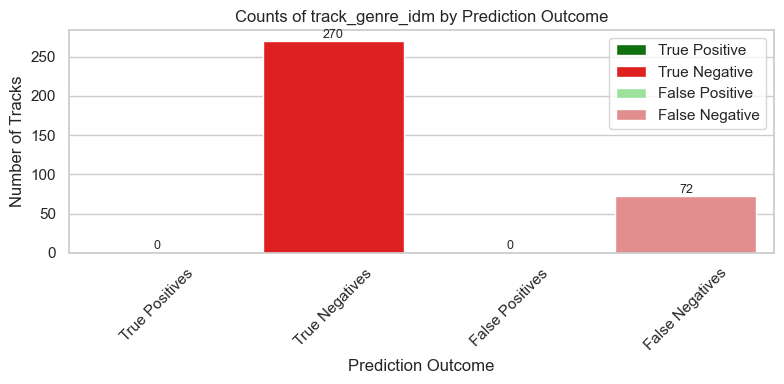

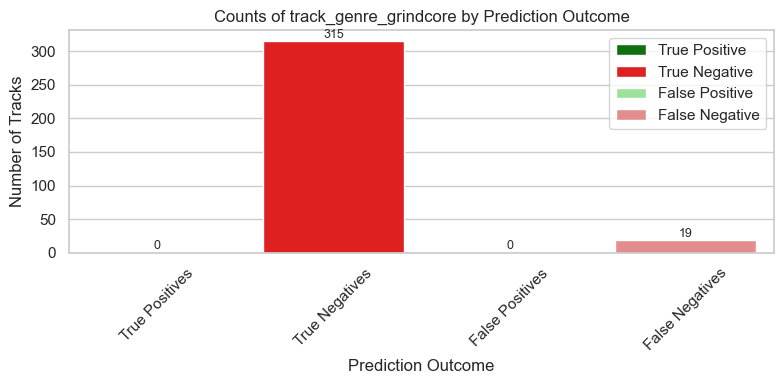

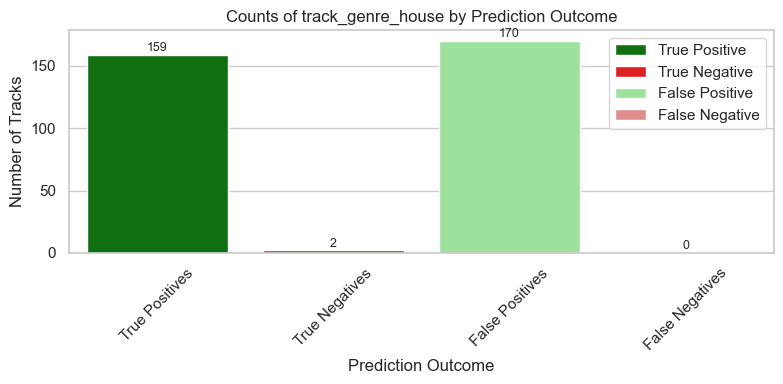

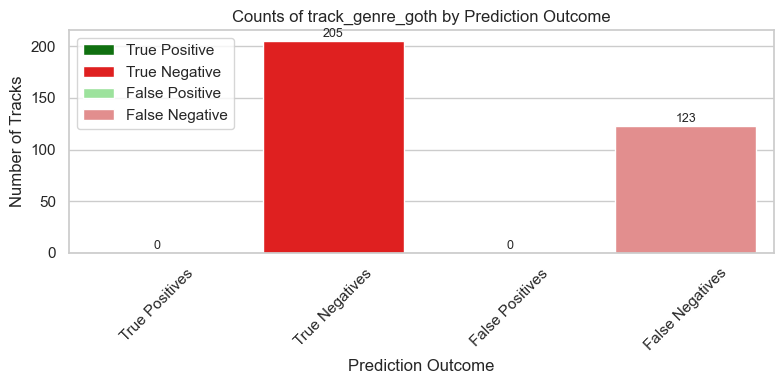

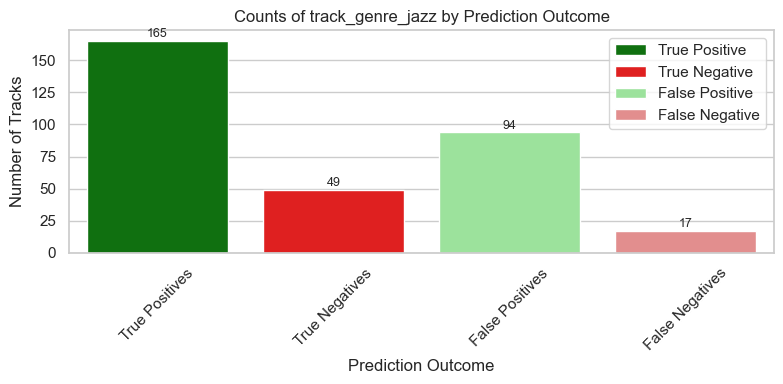

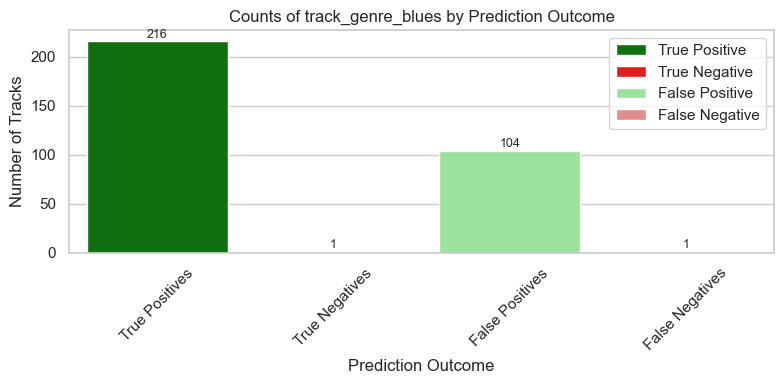

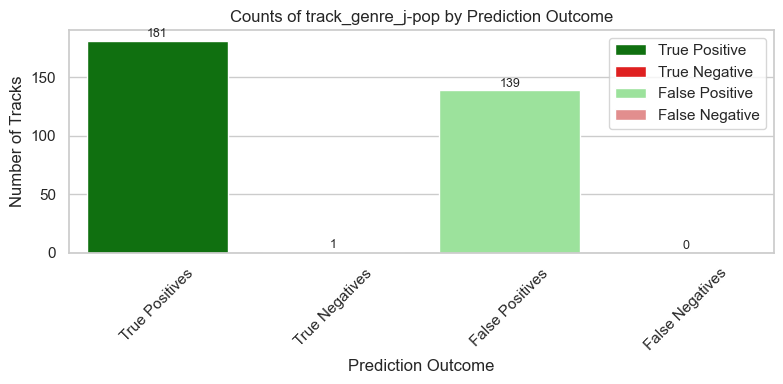

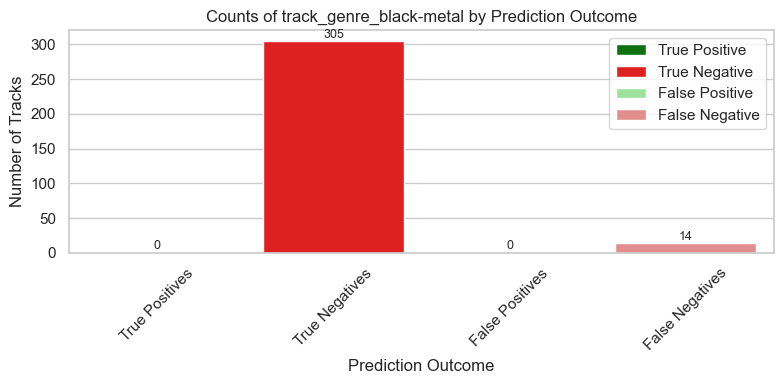

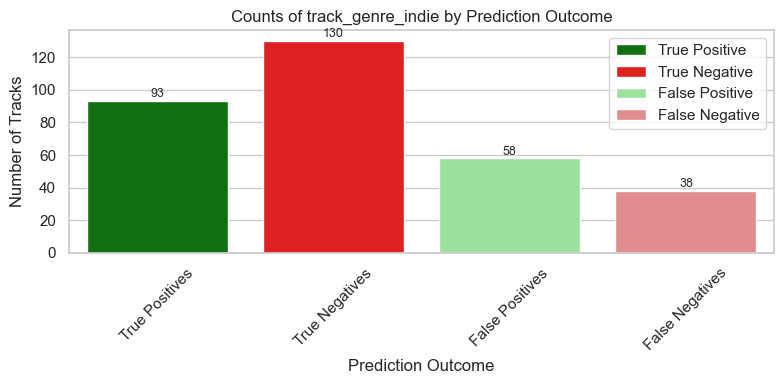

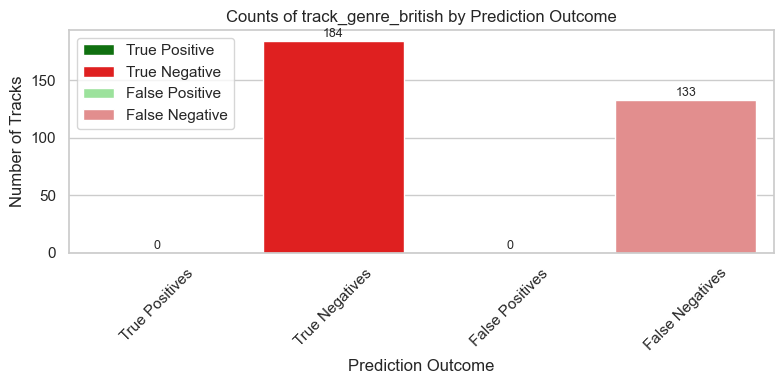

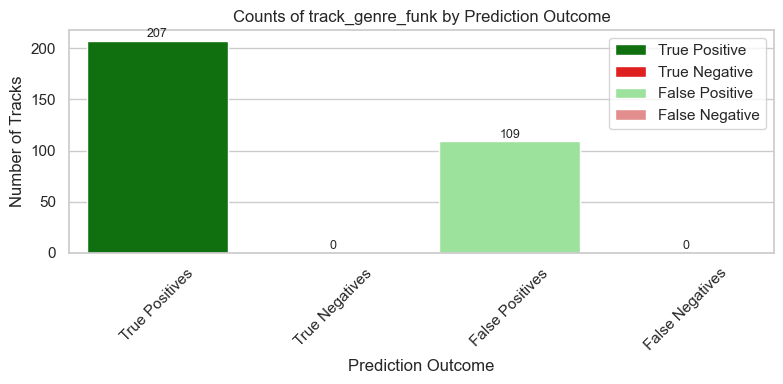

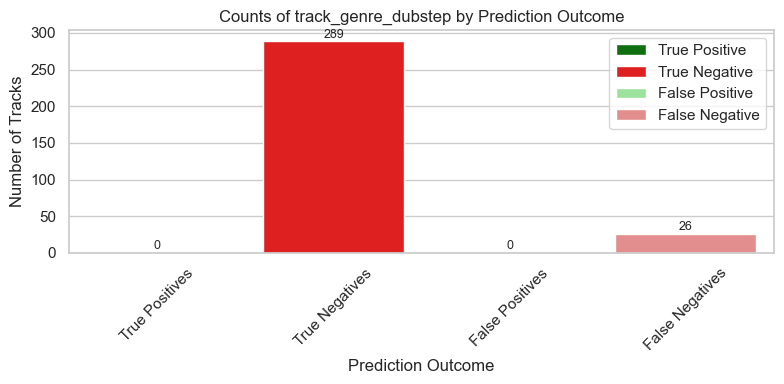

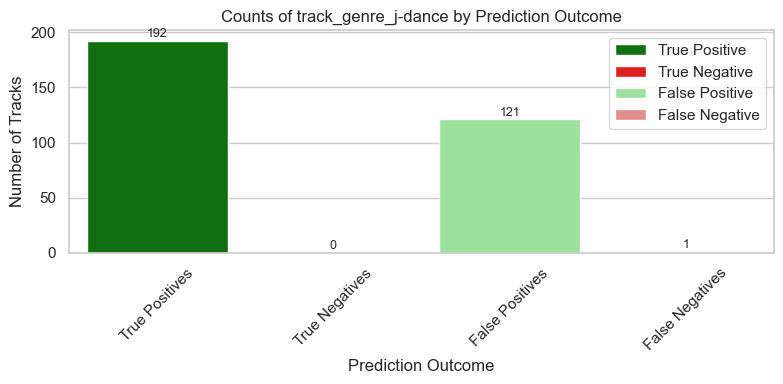

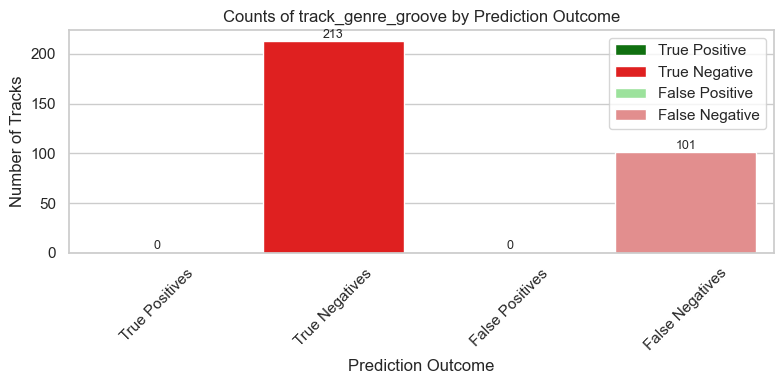

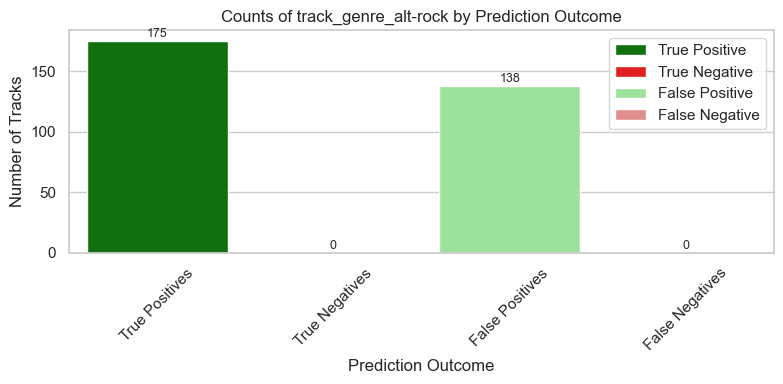

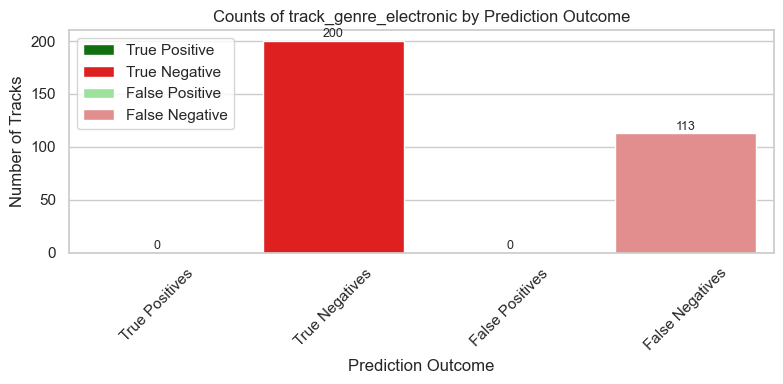

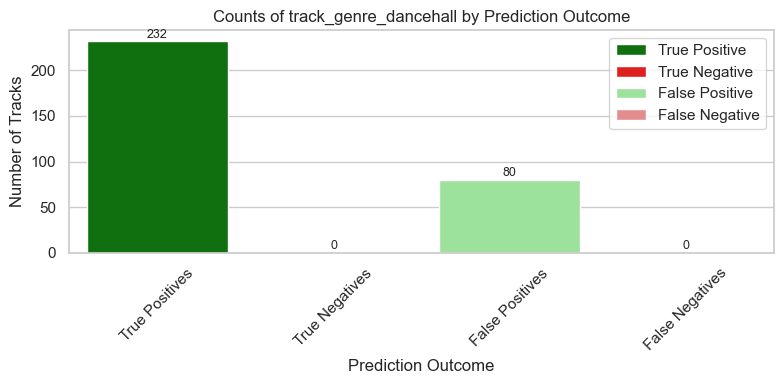

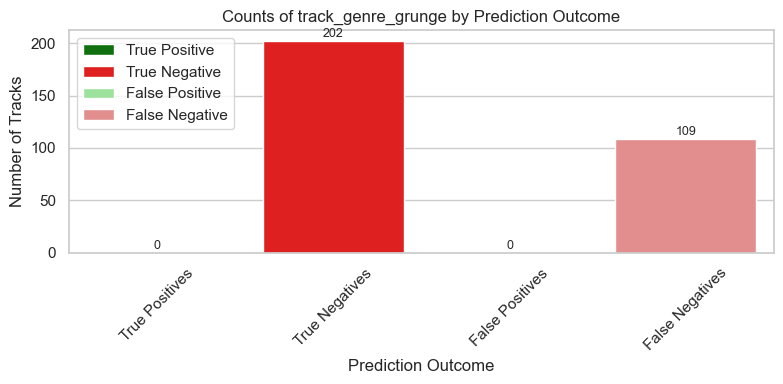

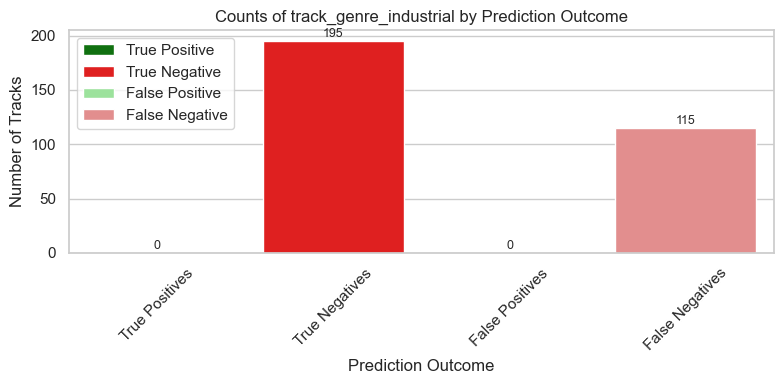

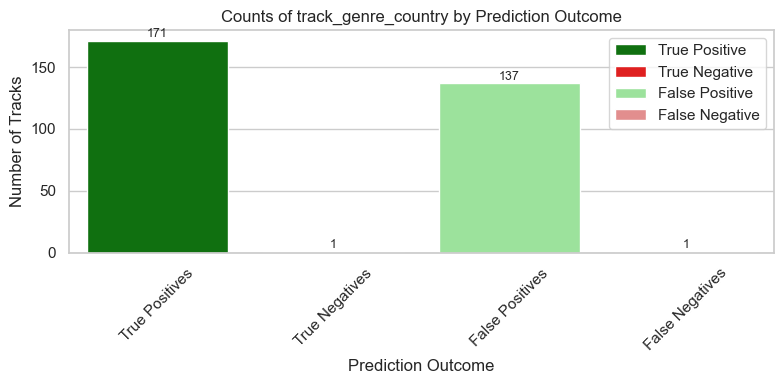

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: prettier style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# --- Genre Counts per Prediction Outcome ---

# Ensure genre columns are all 0 or 1
genre_cols = [col for col in df.columns if col.startswith("track_genre")]

# If genre values are probabilities or standardized, convert to binary
for col in genre_cols:
    df[col] = (df[col] > 0.5).astype(int)  # Adjust threshold if needed
    # df[col].apply(pd.Series.unique)

# Define the prediction outcome groups
groups = {
    "True Positives": true_positives,
    "True Negatives": true_negatives,
    "False Positives": false_positives,
    "False Negatives": false_negatives,
}

# Count genres per group
genre_counts = {
    # group_name: group_df[genre_cols].clip(lower=0).sum() for group_name, group_df in groups.items()
    group_name: (group_df[genre_cols] > 0).astype(int).sum()
    for group_name, group_df in groups.items()
}

# genre_matrix = (df[genre_cols] != -0.09407250308929431).astype(int)
# print(genre_matrix)

# Create a DataFrame
genre_counts_df = pd.DataFrame(genre_counts).T  # Outcomes as rows
# genre_counts_df.to_csv('output.csv', index=False)

top_genres = genre_counts_df.sum(axis=0).sort_values(ascending=False).head(20).index

# Plot barplot for each genre
# for genre in genre_counts_df.columns:
for genre in top_genres:
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        x=genre_counts_df.index,
        y=genre_counts_df[genre].values,
        hue=["True Positive", "True Negative", "False Positive", "False Negative"],
        palette=["green", "red", "lightgreen", "lightcoral"],
    )

    # Add value labels above bars
    for i, value in enumerate(genre_counts_df[genre].values):
        ax.text(i, value + 0.5, str(int(value)), ha="center", va="bottom", fontsize=9)

    plt.title(f"Counts of {genre} by Prediction Outcome")
    plt.ylabel("Number of Tracks")
    plt.xlabel("Prediction Outcome")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [48]:
# # Optional: for nicer plot styles
# sns.set(style="whitegrid")
# plt.rcParams["figure.figsize"] = (10, 5)

# # df_no_genres = df.loc[:, ~df.columns.str.contains("track_genre")]

# # Features only (adjust as needed)
# feature_cols = [
#     col
#     for col in df.columns
#     if col
#     not in [
#         "target_actual",
#         "target_pred",
#         "track_id",
#         "artists",
#         "album_name",
#         "track_name",
#         "valence",
#     ]
# ]

# print(feature_cols)

# # Mean summary per category
# summary_df = pd.DataFrame(
#     {
#         "False Negatives": false_negatives[feature_cols].mean(),
#         "False Positives": false_positives[feature_cols].mean(),
#         "True Positives": true_positives[feature_cols].mean(),
#         "True Negatives": true_negatives[feature_cols].mean(),
#         # "All Data": df[feature_cols].mean(),
#     }
# )

# # Transpose for easier plotting
# summary_df = summary_df.T


# # --- Comparison Bar Plot for of each genre  ---
# # Choose top 10 most differing features that are ONLY GENRES (by std deviation across groups)
# diff_features = (
#     summary_df.filter(like="track_genre")
#     .std()
#     .sort_values(ascending=False)
#     # .head(10)
#     .index
# )

# for feature in diff_features:
#     summary_df[feature].plot(
#         kind="bar", title=f"{feature} across Prediction Groups", ylabel="Mean Value"
#     )
#     plt.xticks(rotation=45)
#     plt.grid(axis="y")
#     plt.tight_layout()
#     plt.show()